# Project 05 -- Anthony Micco

**TA Help:** N/A

**Collaboration:** N/A

**Internet Resources:** N/A

**ChatGPT, Gemini, Claude, etc:** N/A

**Link to AI Chat History**: None

**OVERALL MESSAGE:** Any time that you used anything except your brain to solve the questions in these projects, you need to disclose such resources at the start of the project, with details about your usage of the tools.

**YOUR OWN WORK:** Even when you utilize other resources, do NOT just copy and paste.  Write all explanations in your own words, using several sentences in English, which are understandable and which you wrote (and did not just copy and paste).

## Question 1

In [11]:
# showing the lightning.py file
!cat intro_mlops_2/src/lightning.py

import pytorch_lightning as pl
import torch
from torch import nn

class WineQualityClassifier(pl.LightningModule):
    
    def __init__(self, model, learning_rate, epochs):
        super().__init__()
        self.save_hyperparameters(ignore=["model"])
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self,x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch                      # splits out data (`x`) and labels (`y`)
        logits = self(x)                  # passes data into models forward method
        loss = self.loss_fn(logits, y)    # calcs loss based on logits (output of model) and ground truth
        self.log("train_loss", loss)      # this is a special method that logs the loss at each step
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

    def validation_step(self, batch, batch_idx):
        x,

1.1) The general flow of this setup is that all the logic and training of the model occurs within the WineQualityClassifier object define and we do not have to call the previous trainer functions we defined in the previous function. This allows to have a more clean, modular design as most of the training logic is in one location in the class as opposed to in multiple different files. 

## Question 2

In [12]:
#reading in data from wine quality dataset to see head
import pandas as pd

data = pd.read_csv('/anvil/projects/tdm/data/wine/wine_quality_type.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [13]:
data["type"].value_counts()

type
white    4898
red      1599
Name: count, dtype: int64

In [14]:
#dropping "type" column from dataset
data.drop("type", axis=1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [15]:
#showing the data_loader.py file
!cat intro_mlops_2/src/data_loader.py | head -n 45

import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
np.random.seed(42)

class WineQualityDataModule(pl.LightningDataModule):

    def __init__(self, data_path, batch_size=32,train_split=0.8):
        super().__init__()
        self.data_path = data_path
        self.batch_size = batch_size
        self.train_split = train_split

    def setup(self, stage=None):
        # Load and preprocess data
        data = pd.read_csv(self.data_path).dropna()

        # Create quality bins
        def bin_quality(quality):
            if quality <= 4:
                return 0  # Bad
            elif quality <= 7:
                return 1  # Mid
            else:
                return 2  # Good

        # Apply binning
        data['quality_binned'] = data['quality'].apply(bin_quality)

      

In [19]:
#showing the main.py file
!cat intro_mlops_2/main.py 

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from pathlib import Path

from src.lightning import WineQualityClassifier
from src.data_loader import WineQualityDataModule
from src.neural_net import SimpleNN
from src.config import DATA_PATH, LOGS_PATH, MODELS_PATH, PLOTS_PATH, TRAIN_SPLIT, BATCH_SIZE, LEARNING_RATE, EPOCHS, INPUT_SIZE, NUM_CLASSES

# set seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

def main():
    """
    Using Path objects makes it really easy to modify paths when we refactor - look up pathlib docs if you want to learn more!
    Normally we would put these in a global file and import them but we will not do that for this project (but feel free too!)
    """
    
    #instantiating the model
    # Initialize model, loss function, optimizer    
    simple_nn = SimpleNN(INPUT_SIZE, NUM_CLASSES)
    model = WineQualityClassifier(simple_nn, learning_rate=LEARNING_RATE, epochs=E

In [22]:
#running the pipeline
!python intro_mlops_2/main.py

/usr/local/lib/python3.12/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
2026-02-21 09:48:06.913043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771685286.930456     898 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771685286.935873     898 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1

## Question 3

In [23]:
#defining the print_directory_tree function
#getting the current state of the intro-mlops-1 repo
import os

def print_directory_tree(root_dir, max_depth=3):
  root_dir = os.path.abspath(os.path.expanduser(root_dir))

  if not os.path.exists(root_dir):
    print(f"Path does not exist: {root_dir}")
    return

  for root, dirs, files in os.walk(root_dir):
    # Skip hidden directories like .git
    dirs[:] = [d for d in dirs if not d.startswith(".") and d != ("__pycache__")]
    files = [f for f in files if not f.startswith(".")]

    level = root.replace(root_dir, "").count(os.sep)
    if level >= max_depth:
      continue

    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")

    subindent = " " * 4 * (level + 1)
    for f in files:
      print(f"{subindent}{f}")

In [24]:
#printing the tree
root_path = "~/TDM 302/Project05/intro_mlops_2/"
print_directory_tree(root_path, max_depth=3)

intro-mlops-2/
    requirements.txt
    README.md
    app.py
    main.py
    __init__.py
    src/
        visualization.py
        neural_net.py
        lightning.py
        __init__.py
        data_loader.py
        metrics.py
        trainer.py
    data/
        data.csv
    configs/
        model.yaml
        validation.py
        config.py
    plots/
        accuracy_plot.png
        training_loss_plot.png
    logs/
        training.log
        debug.log
        error.log
        results.log
    models/
        label_encoder.pkl
        best_model.pth
    notebooks/
        anthony-micco-project05.ipynb
        analysis.ipynb


In [30]:
#checking to ensure the configuration file runs correctly
import sys
from pathlib import Path

sys.path.append(str(Path("../..").resolve()))

from intro_mlops_2.configs.validation import load_config
from pathlib import Path

path = Path("~/TDM 302/Project05/intro_mlops_2/configs/model.yaml").expanduser()
config = load_config(path)
print(config)
print("training: ", config.training)
print("model: ", config.model)

training=TrainingConfig(train_split=0.8, batch_size=32, learning_rate=0.001, epochs=5) model=ModelConfig(input_size=11, num_classes=3)
training:  train_split=0.8 batch_size=32 learning_rate=0.001 epochs=5
model:  input_size=11 num_classes=3


In [31]:
#Changing a value in the model.yaml that would break it 
#Changed batch_size from 32 to 30.5 (Needs to be an int, not float)
path = Path("~/TDM 302/Project05/intro_mlops_2/configs/model.yaml").expanduser()
config = load_config(path)
print(config)
print("training: ", config.training)
print("model: ", config.model)

ValidationError: 1 validation error for FullConfig
training.batch_size
  Input should be a valid integer, got a number with a fractional part [type=int_from_float, input_value=30.5, input_type=float]
    For further information visit https://errors.pydantic.dev/2.12/v/int_from_float

## Question 4

In [41]:
#checking to see the validation results
!python -m intro_mlops_2.main

/usr/local/lib/python3.12/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
2026-02-21 10:33:30.571918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771688010.589318    2072 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771688010.594762    2072 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1

In [43]:
#checking out the logs
root_path = "~/TDM 302/Project05/lightning_logs" # adjust as needed
print_directory_tree(root_path, max_depth=3)

lightning_logs/
    version_0/
        events.out.tfevents.1771620211.jupyter-x-amicco.1728.0
    version_10/
        hparams.yaml
        events.out.tfevents.1771624098.jupyter-x-amicco.2706.0
    version_17/
        events.out.tfevents.1771687819.jupyter-x-amicco.1892.0
    version_7/
        events.out.tfevents.1771623345.jupyter-x-amicco.2473.0
        hparams.yaml
    version_19/
        events.out.tfevents.1771687954.jupyter-x-amicco.2005.0
        hparams.yaml
    version_13/
        hparams.yaml
        events.out.tfevents.1771624720.jupyter-x-amicco.2890.0
        checkpoints/
            epoch=49-step=8150.ckpt
    version_9/
        events.out.tfevents.1771623582.jupyter-x-amicco.2614.0
        hparams.yaml
    version_3/
        events.out.tfevents.1771621761.jupyter-x-amicco.2035.0
        hparams.yaml
    version_4/
        events.out.tfevents.1771621892.jupyter-x-amicco.2105.0
        hparams.yaml
    version_14/
        hparams.yaml
        events.out.tfevents.177168451

In [47]:
#running the pipeline with the logs and callbacks enabled
!python -m intro_mlops_2.main

/usr/local/lib/python3.12/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
|                             Training started...                              |
/usr/local/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/x-amicco/TDM 302/Project05/intro_mlops_2/models exists and is not empty.

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | SimpleNN         | 3.0 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.12/site-packages/torch/cuda/__init__.p

In [48]:
# checking the content of the logs directory
root_path = "~/TDM 302/Project05/intro_mlops_2/logs/" 
print_directory_tree(root_path, max_depth=3)

logs/
    wine_quality/
        version_0/
            metrics.csv
            hparams.yaml


In [49]:
#checking the content of the models directory
root_path = "~/TDM 302/Project05/intro_mlops_2/models/"
print_directory_tree(root_path, max_depth=3)

models/
    label_encoder.pkl
    best-epoch=04-val_loss=0.04.ckpt
    best_model.pth


## Question 5

In [52]:
#showing the updated structure of main.py
!cat intro_mlops_2/main.py 

import sys
from pathlib import Path
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pathlib import Path

from intro_mlops_2.configs.config import *
from intro_mlops_2.src.data_loader import WineQualityDataModule
from intro_mlops_2.src.lightning import WineQualityClassifier
from intro_mlops_2.src.neural_net import SimpleNN
from intro_mlops_2.src.see_runs import see_runs

# set seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


def main():
    """
    Using Path objects makes it really easy to modify paths when we refactor - look up pathlib docs if you want to learn more!
    Normally we would put these in a global file and import them but we will not do that for this project (but feel free too!)
    """
    PROJECT_ROOT = 

In [55]:
#running the model
!python -m intro_mlops_2.main

2026/02/21 11:18:00 INFO mlflow.tracking.fluent: Experiment with name 'WineQualityClassifier' does not exist. Creating a new experiment.
/usr/local/lib/python3.12/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
2026-02-21 11:18:01.618442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771690681.635970    3166 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771690681.641564    3166 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771690681.656220    3166 computation_placer.cc:177] computation plac

In [57]:
#checking the content of the mlruns directory
root_path = "~/TDM 302/Project05/mlruns/"
print_directory_tree(root_path, max_depth=3)

mlruns/
    635941224671995772/
        meta.yaml
        d179bc6fadcb45d4848ffa191cc18d97/
            meta.yaml
        models/
    0/
        meta.yaml


                             run_id     start_time epochs  learning_rate  \
0  d179bc6fadcb45d4848ffa191cc18d97  1771690681065   None            NaN   

   val_loss  val_accuracy  
0  0.039382      0.993077  


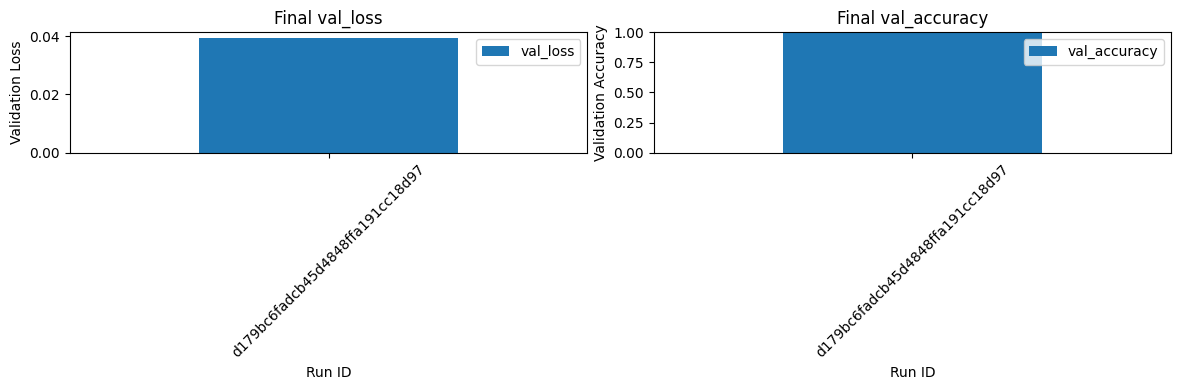

Best run: d179bc6fadcb45d4848ffa191cc18d97 with val_loss=0.0394 and val_accuracy=0.9931


,run_id,start_time,epochs,learning_rate,val_loss,val_accuracy
0,d179bc6fadcb45d4848ffa191cc18d97,1771690681065,None,NaN,0.039382,0.993077


In [58]:
#seeing the runs using see_runs
from intro_mlops_2.src.see_runs import see_runs

see_runs()

## Pledge

By submitting this work I hereby pledge that this is my own, personal work. I've acknowledged in the designated place at the top of this file all sources that I used to complete said work, including but not limited to: online resources, books, and electronic communications. I've noted all collaboration with fellow students and/or TA's. I did not copy or plagiarize another's work.

> As a Boilermaker pursuing academic excellence, I pledge to be honest and true in all that I do. Accountable together – We are Purdue.

https://www.purdue.edu/odos/osrr/honor-pledge/
